## Evaluación y Optimización del Modelo

Primero importamos las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

Ahora, cargamos los datos preprocesados:

In [2]:
filename = 'C:/Users/luis_/OneDrive/Documentos/rh_datos_procesados.csv'
    
df = pd.read_csv(filename)

## Entrenando modelo con el clasificador Árbol de Decisiones

Configuramos los datos de entrenamiento:

In [3]:
from sklearn.model_selection import train_test_split

features = ['satisfaction_level', 'last_evaluation']

X, X_test, y, y_test = train_test_split(df[features].values, df['left'].values, test_size = 0.15, random_state = 1)

Se implementa un árbol de decisión con max_depth=5 para crear el modelo con k-fold cross validation:

In [4]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 5)

 Ejecutamos el algoritmo stratified k-fold cross validation, usando la función model_selection.cross_val_score: 

In [5]:
from sklearn.model_selection  import cross_val_score

scores = cross_val_score(estimator = clf, X = X, y = y, cv = 10)

print('precisión = {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

precisión = 0.92 +/- 0.01


Ahí, se entrenaron 10 variaciones del modelo clf usando stratified k-fold validation.

Vamos a ver las puntuaciones:

In [6]:
print(scores)

[0.92235294 0.91529412 0.92784314 0.92941176 0.9254902  0.92705882
 0.91294118 0.91607843 0.92235294 0.9277865 ]


Se define una clase personalizada para calcular las precisiones de clases para k-fold cross validation:

In [7]:
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

def cross_val_class_score(clf, X, y, cv = 10):
    
    Kfold = (StratifiedKFold(n_splits = cv).split(X, y))
    
    class_accuracy = []
    
    for k, (train, test) in enumerate(Kfold):
        
        clf.fit(X[train], y[train])
        
        y_test = y[test]
        
        y_pred = clf.predict(X[test])
        
        cmat = confusion_matrix(y_test, y_pred)
        
        class_acc = cmat.diagonal() / cmat.sum(axis = 1)
        
        class_accuracy.append(class_acc)
        
        print('fold: {:d} precisión: {:s}'.format(k + 1, str(class_acc)))
        
    return np.array(class_accuracy)

Después de haber definido la función, se puede calcular la precisión de las clases:

In [8]:
scores = cross_val_class_score(clf, X, y)

print('precisión = {} +/- {}'.format(scores.mean(axis=0),scores.std(axis=0)))

fold: 1 precisión: [0.98558187 0.72039474]
fold: 2 precisión: [0.98559671 0.68976898]
fold: 3 precisión: [0.98971193 0.72937294]
fold: 4 precisión: [0.98765432 0.74257426]
fold: 5 precisión: [0.99074074 0.71617162]
fold: 6 precisión: [0.98971193 0.72607261]
fold: 7 precisión: [0.98251029 0.68976898]
fold: 8 precisión: [0.98559671 0.69306931]
fold: 9 precisión: [0.9845679  0.72277228]
fold: 10 precisión: [0.98352214 0.74917492]
precisión = [0.98651946 0.71791406] +/- [0.00266344 0.0200439 ]


Ahora, se calcula la curva de validación con model_selection.validation_curve:

In [9]:
from sklearn.model_selection import validation_curve

clf = DecisionTreeClassifier()

max_depth_range = np.arange(3, 20, 1)

train_scores, test_scores = validation_curve(estimator = clf, X = X, y = y, param_name = 'max_depth', param_range = max_depth_range, cv = 5)

Visualizando la curva de validación:

In [10]:
# Función para trazar la curva de validación

def plot_validation_curve(train_scores, test_scores, param_range, xlabel='',log=False):
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='precisión de entrenamiento')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='precisión de validación')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    
    plt.legend(loc='lower right')
    
    if xlabel:
        plt.xlabel(xlabel)
    
    plt.ylabel('Precisión')
    
    plt.ylim(0.9, 1.0)
    
    return fig
    

Se muestra la gráfica y se guarda:

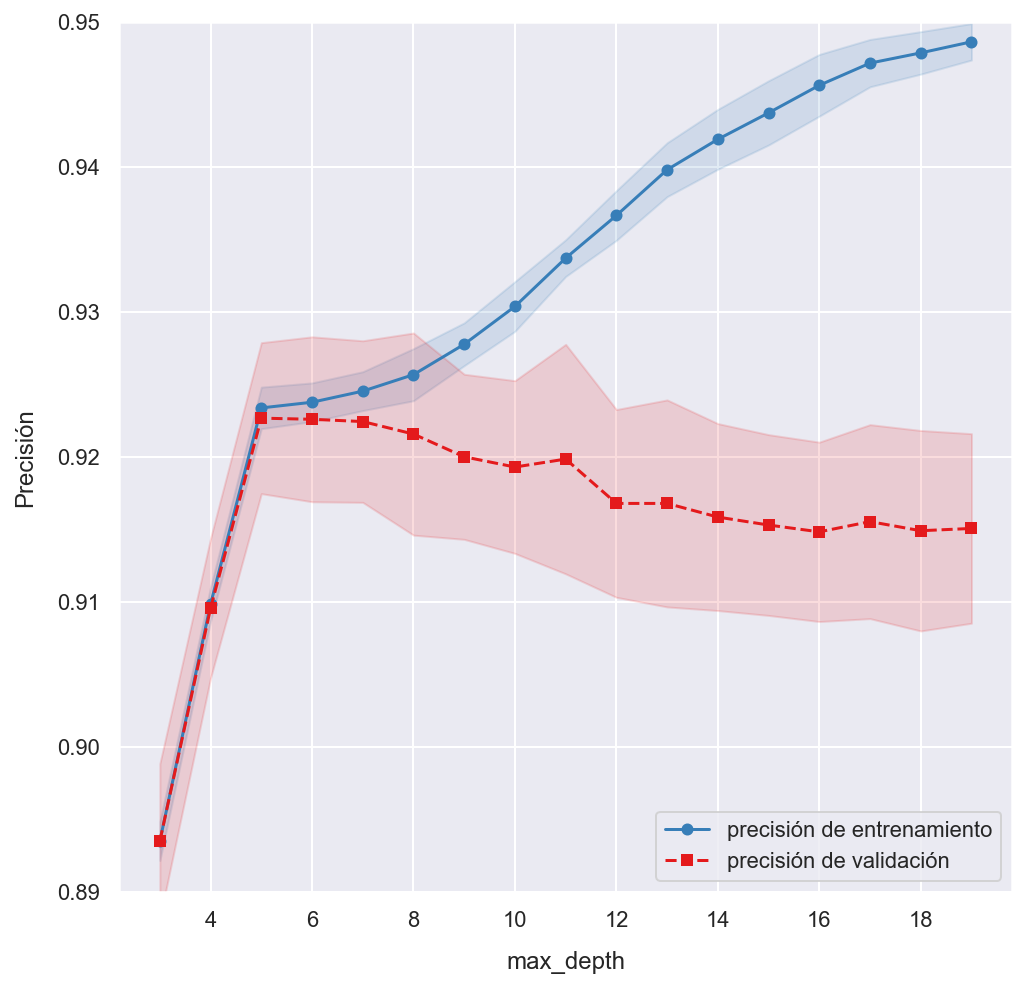

In [11]:
plot_validation_curve(train_scores, test_scores, max_depth_range, xlabel='max_depth')

plt.ylim(0.89, 0.95)

plt.savefig('C:/Users/luis_/OneDrive/Documentos/figures-jointplot.png',bbox_inches='tight', dpi=300)


Según este gráfico, un buen valor para max_depth parece ser 6. En este punto, se puede ver que la precisión de validación ha alcanzado un máximo y que las precisiones de entrenamiento y validación coinciden (dentro del error).

## Reducción de Dimensionalidad con PCA

Después de entrenar una variedad de modelos para predecir la rotación de empleados con el Human Resource Analytics dataset, todavía se tiene que utilizar la mayoría de las variables disponibles.

Determinamos la "feature importance" utilizando un clasificador de árbol de decisión. Luego se selecciona todas las variables disponibles y se forma un árbol de decisiones con el conjunto de datos completo:

In [12]:
features = [
    
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'work_accident',
    'promotion_last_5years', 'department_IT', 'department_RandD',
    'department_accounting', 'department_hr', 'department_management',
    'department_marketing', 'department_product_mng', 'department_sales',
    'department_support', 'department_technical', 'salary_high',
    'salary_low', 'salary_medium'
]

X = df[features].values

y = df.left.values

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)

clf.fit(X, y)

DecisionTreeClassifier(max_depth=10)

Habiendo entrenado un modelo rápido, se aprovecha para ver qué tan importante es cada feature para hacer predicciones usando el atributo feature_importances_ de clf. Luego se visualiza en un gráfico de barras:

Text(0.5, 0, 'Feature importance')

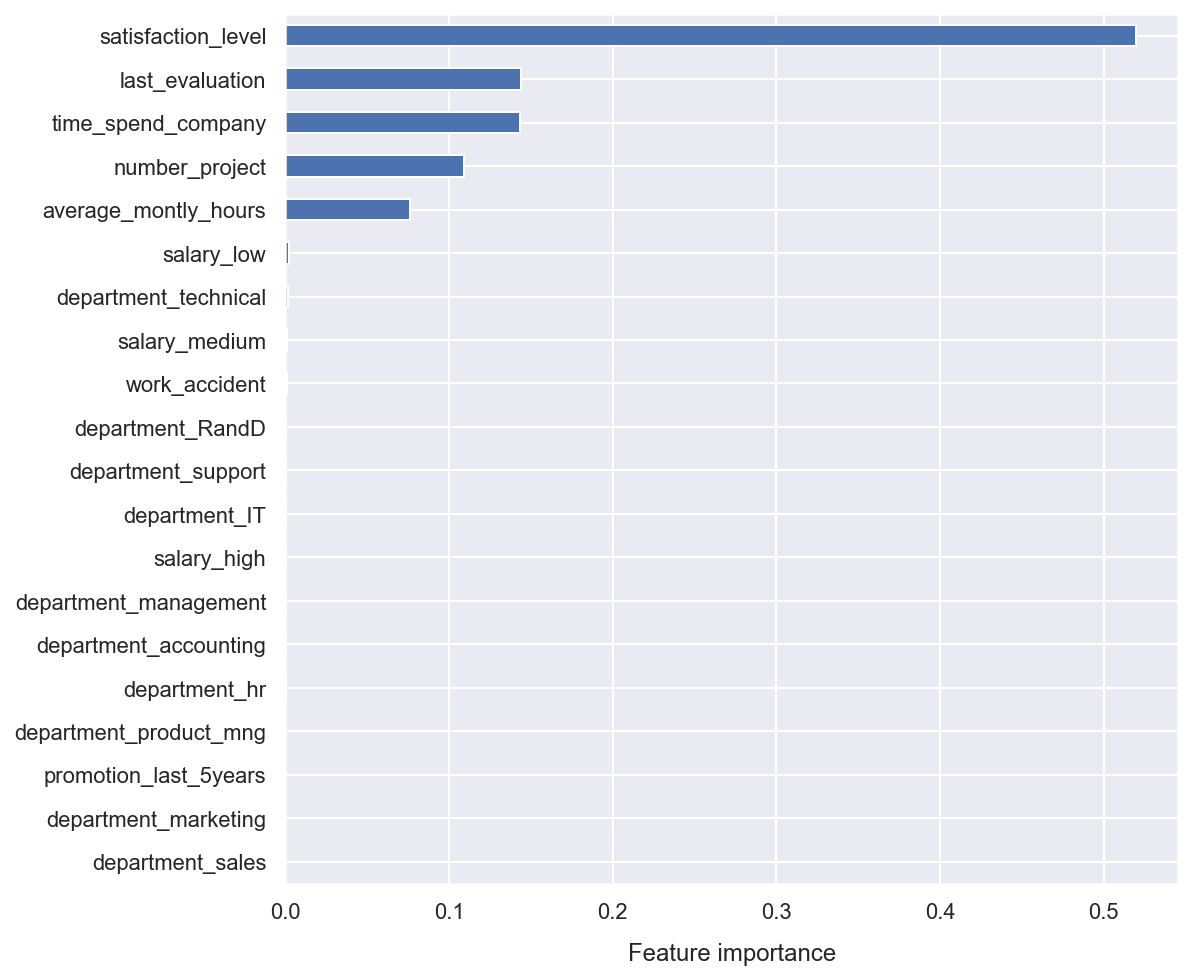

In [13]:
pd.Series(clf.feature_importances_, name='Feature importance', index=df[features].columns).sort_values().plot.barh()

plt.xlabel('Feature importance')

Como se muestra en el gráfico de barras, hay varias variables que son de gran importancia cuando se trata de hacer predicciones, y el resto parece tener una importancia cercana a cero.

Dejamos a un lado las cinco variables más importantes del gráfico anterior para que se puedan usar para modelar más adelante, y luego seleccionamos el resto para usar en el algoritmo PCA:

In [14]:
importances = list(pd.Series(clf.feature_importances_, index=df[features].columns).sort_values(ascending=False).index)

low_importance_features = importances[5:]

high_importance_features = importances[:5]

Ahora, se muestran la lista de variables features de menor importancia:

In [15]:
np.array(low_importance_features)

array(['salary_low', 'department_technical', 'salary_medium',
       'work_accident', 'department_RandD', 'department_support',
       'department_IT', 'salary_high', 'department_management',
       'department_accounting', 'department_hr', 'department_product_mng',
       'promotion_last_5years', 'department_marketing',
       'department_sales'], dtype='<U22')

Luego, se muestra la lista de variables features de mayor importancia:

In [16]:
np.array(high_importance_features)

array(['satisfaction_level', 'last_evaluation', 'time_spend_company',
       'number_project', 'average_montly_hours'], dtype='<U20')

In [19]:
df = df.astype(float)

Ejecutamos el algoritmo PCA:

In [20]:
from sklearn.decomposition import PCA

pca_features = [
    'salary_low', 'department_technical', 'department_support',
    'work_accident', 'salary_medium', 'department_IT',
    'department_RandD', 'salary_high', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

X_reduce = df[pca_features]

pca = PCA(n_components=3)

pca.fit(X_reduce)

X_pca = pca.transform(X_reduce)

Chequeo la estructura de los datos:

In [21]:
X_pca.shape

(14999, 3)

Se insertan los componentes principales en el DataFrame: 

In [22]:
df['first_principle_component'] = X_pca.T[0]

df['second_principle_component'] = X_pca.T[1]

df['third_principle_component'] = X_pca.T[2]

Se guarda el conjunto de datos actualizados:

In [23]:
df.to_csv('C:/Users/luis_/OneDrive/Documentos/rh_datos_procesados_pca.csv', index=False)

Luego, se guarda el "fit" PCA: 

In [24]:
import joblib

joblib.dump(pca, 'rh-analisis-pca.pkl')

['rh-analisis-pca.pkl']

## Entrenando un Modelo Listo para Producción

Se seleccionan el top cinco de features de la sección PCA como variables que se usaran en el modelo:

In [25]:
from sklearn.model_selection import train_test_split

faetures = [
    
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]

X, X_test, y, y_test = train_test_split(df[features].values, df['left'].values, test_size = 0.15, random_state = 1)

Se calcula la curva de validación para el árbol de decisión con un max depth range de 2 en 2 hasta 52:

In [26]:
%%time

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

max_depth_range = np.arange(2, 52, 2)

print('Entrenando {} modelos ...'.format(len(max_depth_range)))

train_scores, test_scores = validation_curve(estimator = clf, X = X, y = y, param_name = 'max_depth', 
                                            param_range = max_depth_range, cv = 10)

Entrenando 25 modelos ...
Wall time: 10.2 s


Ahora, se grafica la curva de validación:

(0.95, 1.0)

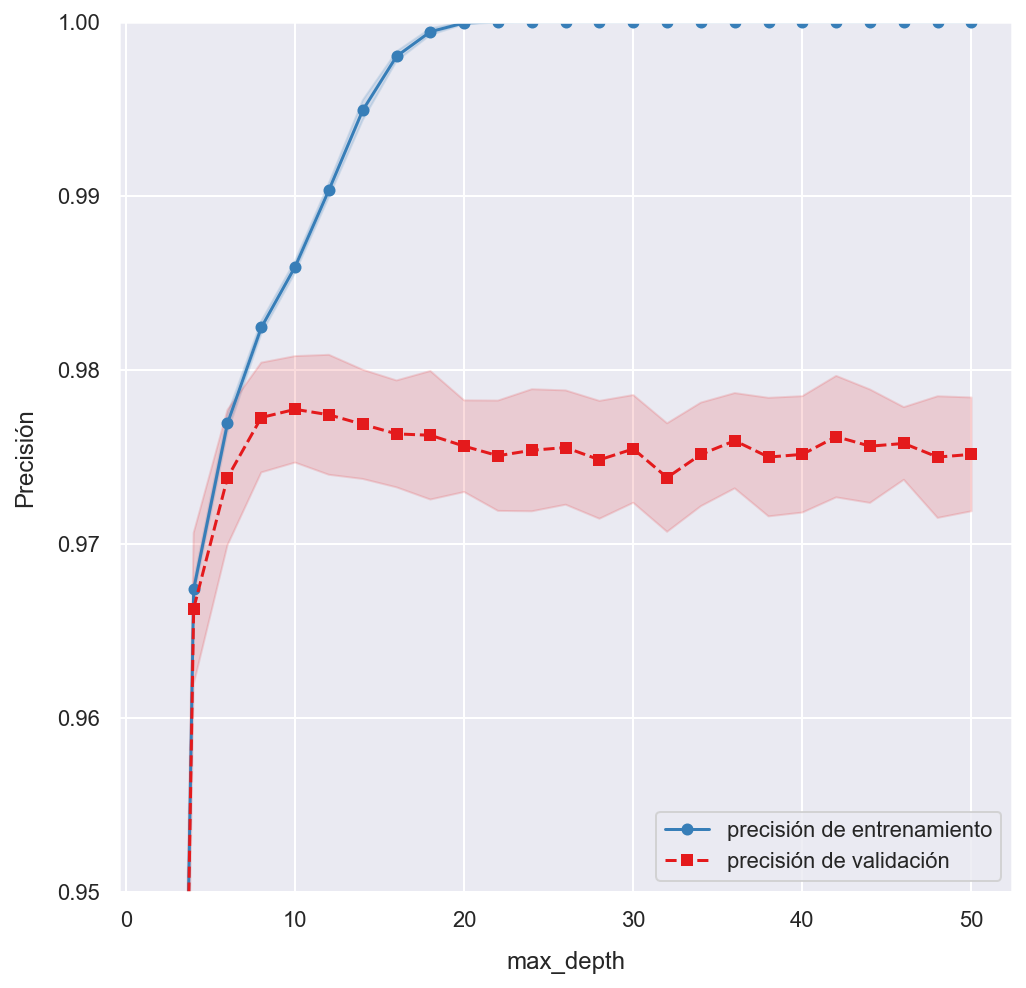

In [27]:
plot_validation_curve(train_scores, test_scores, max_depth_range, xlabel = 'max_depth')

plt.ylim(0.95, 1.0)

Basado en los resultados, se selecciona max_depth = 8 como valor óptimo para usar en el modelo de producción.

Se usa la función cross_val_class_score para chequear la precisión de cada clase en k-fold cross validation:

In [28]:
clf = DecisionTreeClassifier(max_depth = 8)

scores = cross_val_class_score(clf, X, y)

print('precisión = {} +/- {}'.format(scores.mean(axis = 0), scores.std(axis = 0)))

fold: 1 precisión: [0.99279094 0.91118421]
fold: 2 precisión: [0.99691358 0.91089109]
fold: 3 precisión: [0.99691358 0.92079208]
fold: 4 precisión: [0.99485597 0.95049505]
fold: 5 precisión: [0.99794239 0.90759076]
fold: 6 precisión: [0.99691358 0.91419142]
fold: 7 precisión: [0.99588477 0.92409241]
fold: 8 precisión: [0.99074074 0.94059406]
fold: 9 precisión: [0.99176955 0.91419142]
fold: 10 precisión: [0.99176107 0.94059406]
precisión = [0.99464862 0.92346166] +/- [0.00251316 0.01434532]


Como puede verse, este modelo se está desempeñando mucho mejor que los modelos anteriores para la clase 1, con una precisión promedio del 92% +/- 1,5%. Esto se puede atribuir a las variables adicionales que usamos aquí, en comparación con los modelos anteriores que se basaban en solo dos variables.

Se ejecuta un gráfico de caja para visualizar la precisión de cada clase:

Text(0, 0.5, 'Precisión')

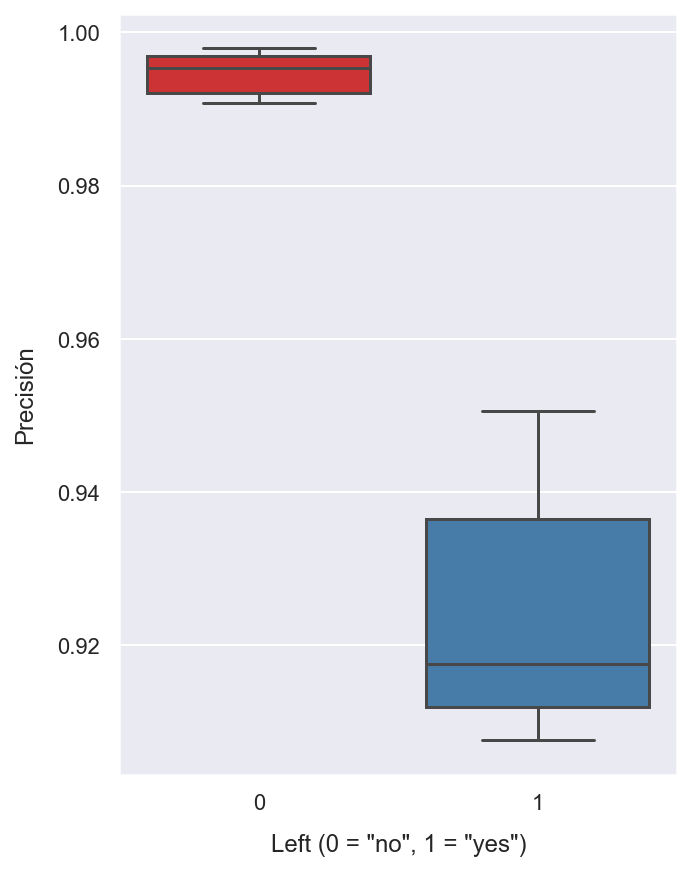

In [29]:
fig = plt.figure(figsize = (5, 7))

sns.boxplot(data = pd.DataFrame(scores, columns = [0, 1]), palette = sns.color_palette('Set1'))

plt.xlabel('Left (0 = "no", 1 = "yes")')

plt.ylabel('Precisión')

Se entrena un modelo con el conjunto completo de datos de entrenamiento y validación (X, y). Luego, se determina la precisión de cada clase para el conjunto de prueba (X_test, y_test):

In [30]:
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(max_depth = 8)

clf.fit(X, y)

y_pred = clf.predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

cmat.diagonal() / cmat.sum(axis = 1) * 100

array([99.35672515, 94.25925926])

Estas precisiones de prueba deben estar dentro o muy cerca del rango de las precisiones de k-fold cross validation que calculamos previamente. Para la clase 0, podemos ver el 99,35%, que se encuentra dentro del rango de k fold del 99,07% al 99,7%, y para la clase 1, se puede ver el 94,25%, que se encuentra también dentro  por del rango de k fold del 90,7% al 95 %.

Ahora, se entrena un nuevo modelo con todos los datos:

In [31]:
features = [
    
     'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]

X = df[features].values

y = df['left'].values

clf = DecisionTreeClassifier(max_depth = 8)

clf.fit(X, y)

DecisionTreeClassifier(max_depth=8)

Luego, se usa el módulo joblib y enviamos el modelo a un archivo binario:

In [32]:
import joblib

joblib.dump(clf, 'rh-analisis-pca-tree.pkl')

['rh-analisis-pca-tree.pkl']

Cargamos el modelo para hacer predicciones:

In [33]:
clf = joblib.load('rh-analisis-pca-tree.pkl')

clf

DecisionTreeClassifier(max_depth=8)

Se selecciona un registro de los datos de entrenamiento y se filtra  en la columna original de variables, suponemos que ese perfil de empleado es "Juan": 

In [34]:
pca_features = [
    
    'salary_low', 'department_technical', 'work_accident',
    'department_support', 'department_IT', 'department_RandD',
    'salary_high', 'salary_medium', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

non_pca_features = [ 
    
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours'
]

juan = df.iloc[8500][pca_features + non_pca_features]

juan

salary_low                  0.00
department_technical        0.00
work_accident               0.00
department_support          0.00
department_IT               0.00
department_RandD            0.00
salary_high                 0.00
salary_medium               1.00
department_management       0.00
department_accounting       0.00
department_hr               0.00
department_sales            1.00
department_product_mng      0.00
promotion_last_5years       0.00
department_marketing        0.00
satisfaction_level          1.00
last_evaluation             0.68
time_spend_company          2.00
number_project              3.00
average_montly_hours      132.00
Name: 8500, dtype: float64

Cargamos el archivo que transforma clases PCA que se había guardado en el disco para usarlo y transformar las variables relevantes de "Juan":

In [35]:
pca = joblib.load('hr-analytics-pca.pkl')

pca_feature_values = pca.transform([juan[pca_features]])[0]

pca_feature_values

array([ 0.04532366,  0.72596045, -0.09833547])

Se crea un vector de predicción para Juan que se puede ingresar en el método de predicción del modelo de clasificación:

In [36]:
X_juan = np.concatenate((juan[non_pca_features].values, pca_feature_values))

X_juan

array([ 1.00000000e+00,  6.80000000e-01,  2.00000000e+00,  3.00000000e+00,
        1.32000000e+02,  4.53236581e-02,  7.25960454e-01, -9.83354688e-02])

Finalmente, está todo listo para ver si el modelo predice si Juan abandonará la compañía:

In [37]:
clf.predict([X_juan])

array([0.])

Esto indica que el modelo ha realizado una predicción arrojando que Juan no abandonará la compañia, ya que fue asignado a la  **class 0**.

Ahora se mostrará que probabilidad ha asignado el modelo a esa predicción, usando el método predict_proba:

In [38]:
clf.predict_proba([X_juan])

array([[0.99616307, 0.00383693]])

El modelo ha asignado un **99% probabilidad que Juan continuará en la  compañía**.